In [1]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")
from detectron2.config import CfgNode as CN

# import some common libraries
import numpy as np
import cv2
import torch
from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config

# import Mask2Former project
from mask2former import add_maskformer2_config
import matplotlib.pyplot as plt


[05/16 16:27:49 d2.data.datasets.coco]: Loaded 728 images with semantic segmentation from /mnt/se3-shared/users/felix/datasets/Drivability/train/images
Registered Drivability_train with 728 images
[05/16 16:27:49 d2.data.datasets.coco]: Loaded 91 images with semantic segmentation from /mnt/se3-shared/users/felix/datasets/Drivability/valid/images
Registered Drivability_val with 91 images


/home/felix/anaconda3/envs/mask2former/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/felix/anaconda3/envs/mask2former/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
meta = MetadataCatalog.get("Drivability_train")

model_weights = "output/Drivability_large_swinT_sem/model_final.pth"
model_config = "configs/scharmstudie/Drivability_swinT_sem.yaml"

# Define paths for image and mask
path = Path("images")
image_name = "0005918_gpslapse_0021"

# Read the image and corresponding mask
im = cv2.imread(str(path / f"{image_name}.JPG"))


In [3]:
cfg = get_cfg()
cfg.MASK_LOGGER = CN()
cfg.MASK_LOGGER.ENABLED = True
cfg.MASK_LOGGER.PERIOD = 1000
cfg.MASK_LOGGER.NUM_SAMPLES = 5
cfg.MASK_LOGGER.SIZE = (640, 640)
cfg.SOLVER.MAX_TO_KEEP = 3

cfg.EARLY_STOPPING = CN()
cfg.EARLY_STOPPING.ENABLED = True
cfg.EARLY_STOPPING.PATIENCE = 5  # Number of evaluations to wait for improvement
cfg.EARLY_STOPPING.MIN_DELTA = 0.001  # Minimum change in metric to be considered as improvement
cfg.EARLY_STOPPING.METRIC_NAME = "sem_seg/mIoU"  # Metric to monitor

add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file(model_config)
cfg.MODEL.WEIGHTS = model_weights
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

Loading config configs/scharmstudie/../cityscapes/semantic-segmentation/swin/../Base-Cityscapes-SemanticSegmentation.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
/home/felix/anaconda3/envs/mask2former/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/16 16:27:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/Drivability_large_swinT_sem/model_final.pth ...


In [9]:
import time
start = time.time()
outputs = predictor(im)
end = time.time()
print(f"Time taken prediction: {end - start} seconds")

start = time.time()
mask = outputs["sem_seg"].argmax(0)
end = time.time()
print(f"Time taken mask: {end - start} seconds")

masks = mask.to("cpu")


[05/16 16:29:26 d2.utils.memory]: Attempting to copy inputs of <function sem_seg_postprocess at 0x71c456c040d0> to CPU due to CUDA OOM
Time taken prediction: 0.7510056495666504 seconds
Time taken mask: 3.8606443405151367 seconds


Semantic segmentation


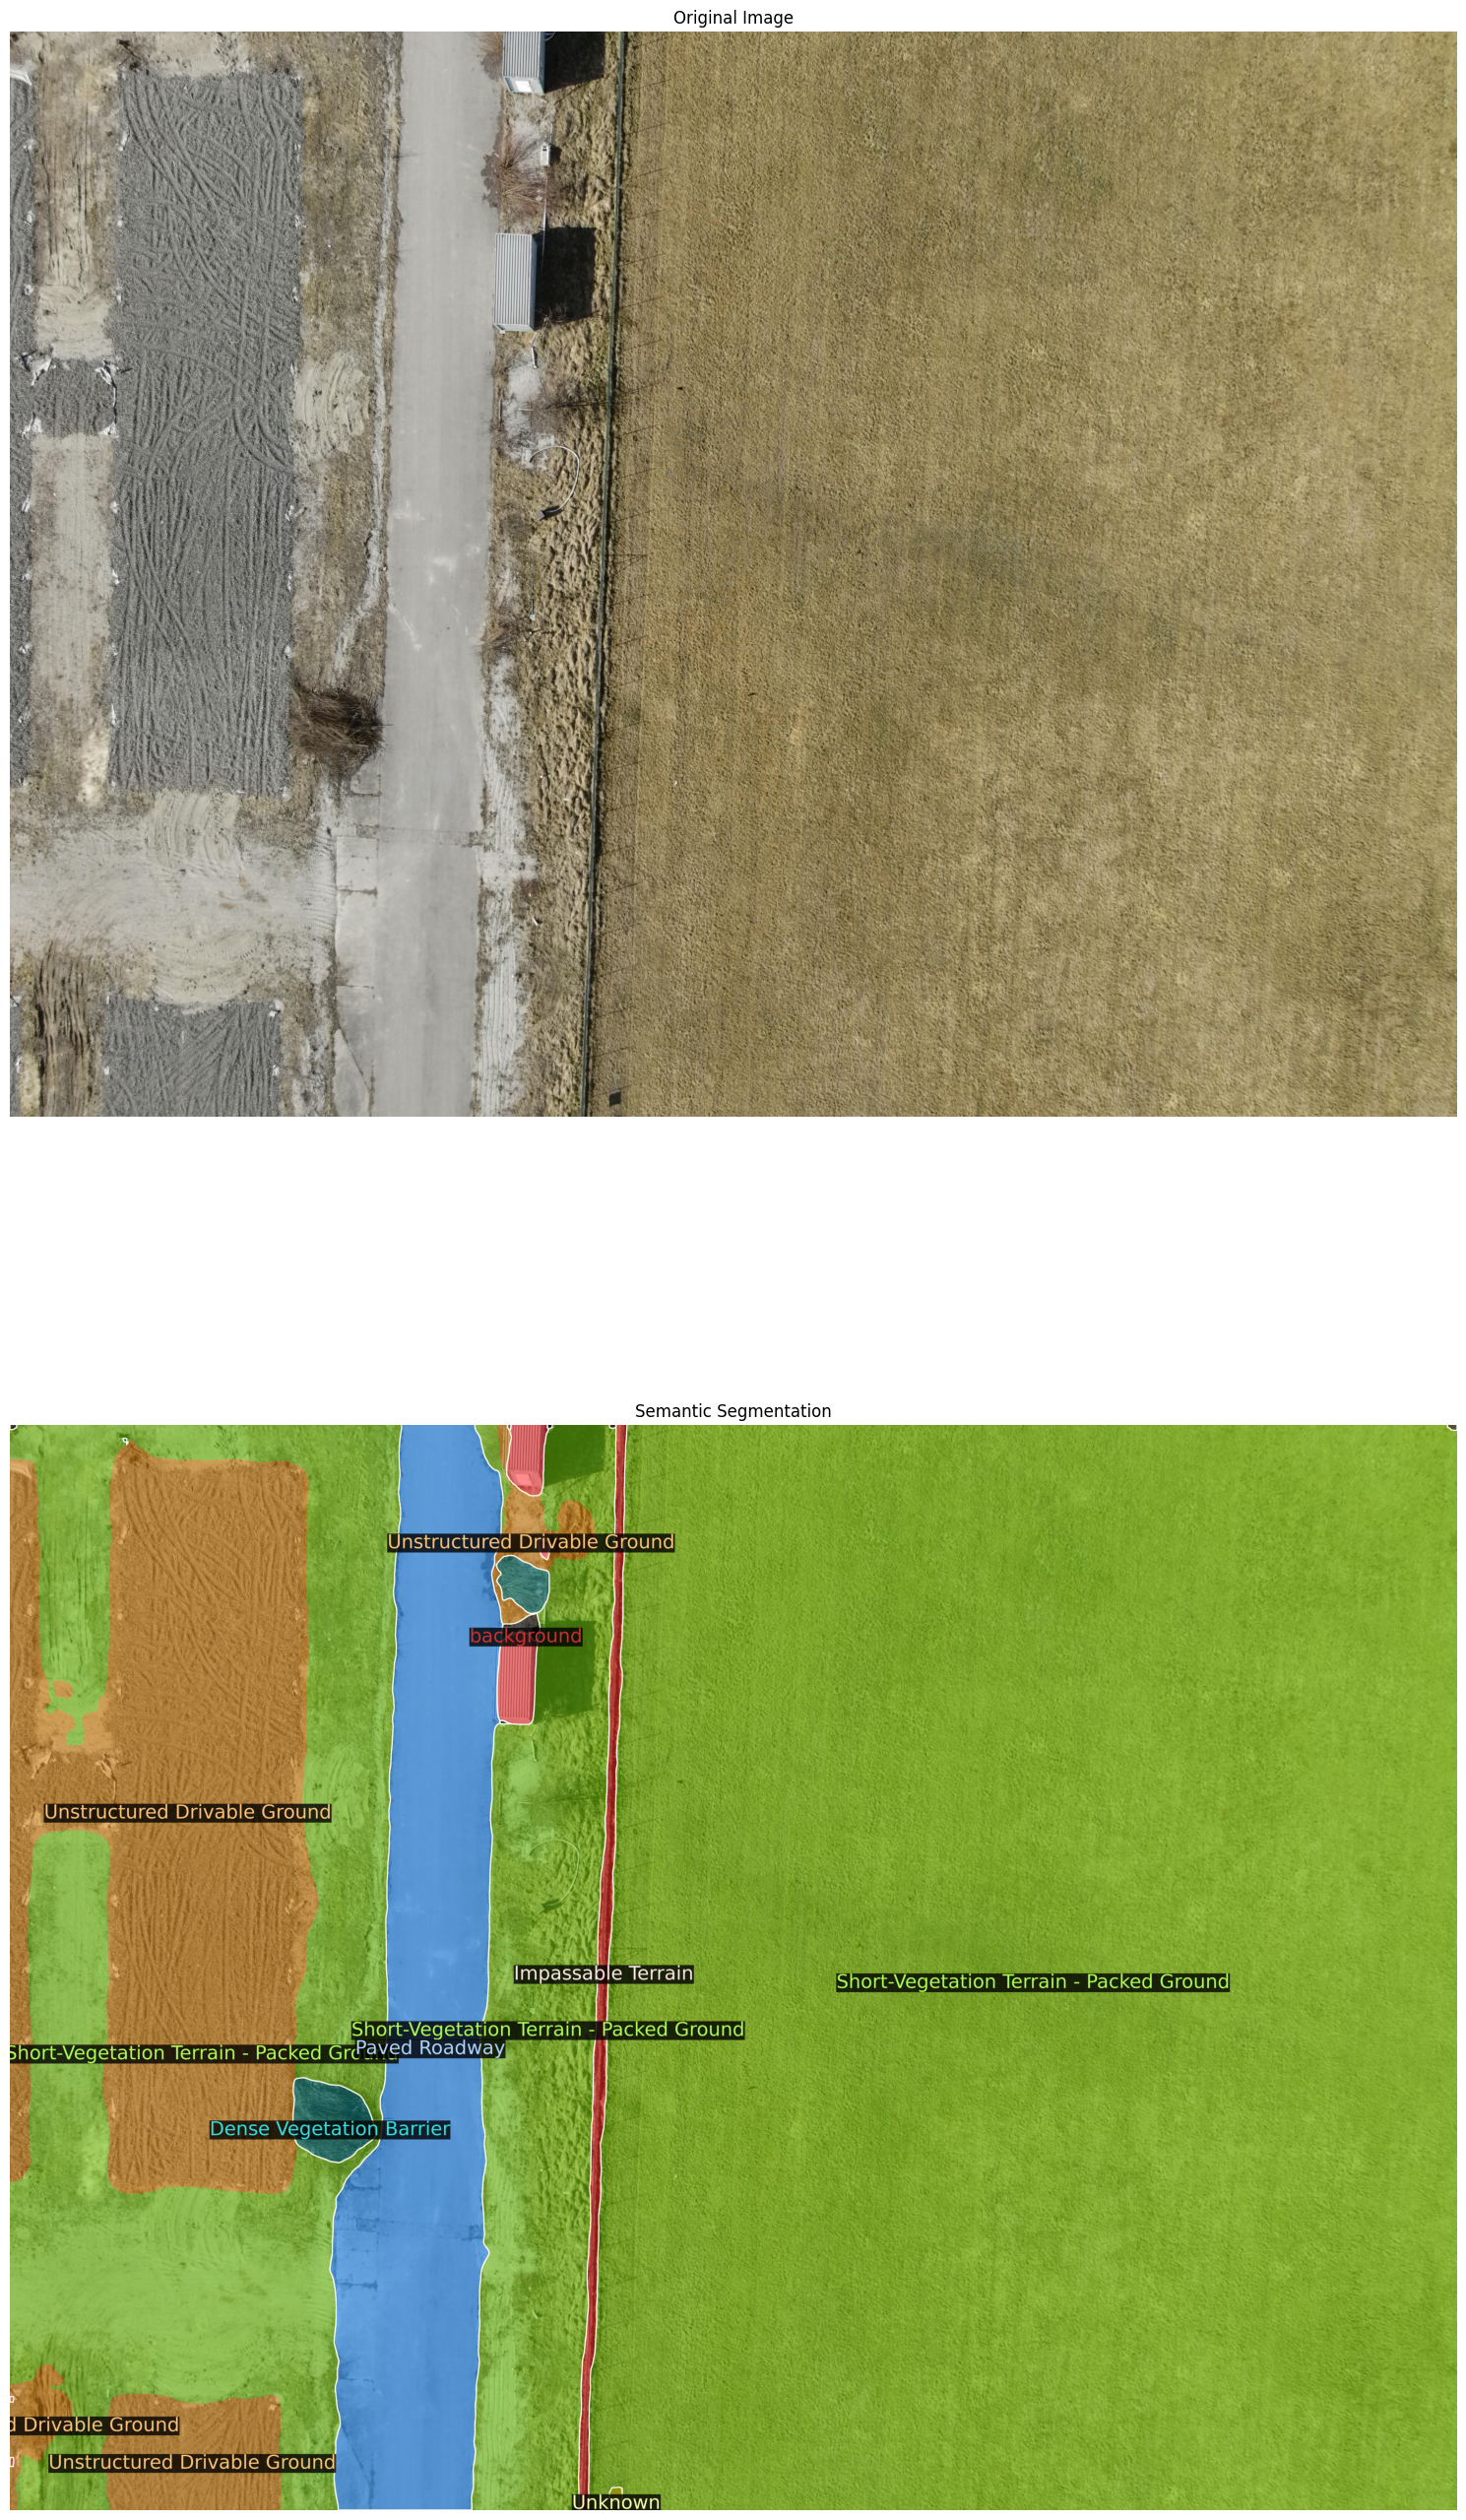

In [6]:
v = Visualizer(im[:, :, ::-1], meta, scale=1.0, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(mask, alpha=0.5).get_image()
print("Semantic segmentation")
# Create a figure with 3 subplots stacked vertically
plt.figure(figsize=(15, 30))

# Plot original image
plt.subplot(2, 1, 1)
plt.imshow(im[:, :, ::-1])
plt.axis('off')
plt.title("Original Image")

# Plot ground truth mask
plt.subplot(2, 1, 2)
plt.imshow(semantic_result)
plt.axis('off')
plt.title("Semantic Segmentation")
plt.tight_layout()
plt.show()
